In [1]:
import sys
from pathlib import Path

import numpy as np
import geopandas as gpd
import rasterio
from pytorch_lightning import Trainer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix

sys.path.append("..")

from src.models import LandCoverMapper

## Load labels with coordinates

In [2]:
def get_labels_dataframe(eval_set: str = 'testing'):
    # Get subset
    labels_path = Path('../data/features/nigeria-cropharvest/labels.geojson')
    gdf = gpd.read_file(labels_path)
    assert eval_set in ['testing', 'validation']
    val_gdf = gdf[gdf['new_set'] == eval_set]
    
    # Drop missing arrays
    arrays_path = Path('../data/features/nigeria-cropharvest/features/arrays')
    existing_arrays_ids = sorted([int(str(path.stem).split('_')[0]) for path in arrays_path.glob('*.h5')])
    missing_files_identifiers = list(set(list(range(1827))) - set(existing_arrays_ids))

    # We don't consider the missing h5 files to ensure a fair comparison with the other models
    val_gdf = val_gdf.loc[~val_gdf['identifier'].isin(missing_files_identifiers)]

    return val_gdf

## Checks for model predictions

### TODOS:
- [x] Get test set predictions of the model (with saved predictions?)
- [x] Check with validation set
- [x] Check if it they all give same results: saved model predictions, predicting again with the saved model in the test set, and querying the map on the test set points
  - Saved model predictions and new run with the model match
  - Querying the map at test set points gives different results! (almost all predicting as binary, as expected)!
  - [ ] Check that data array given to model match those seen during inference 
- [ ] Check neighbours1 model without weighted loss function (has a more balanced recall and precision)

In [3]:
def load_trained_model(results_path):
    preds = np.load(results_path / 'all_preds.npy')
    labels = np.load(results_path / 'all_labels.npy')
    return preds, labels

def get_trained_model_preds_and_checkpoint(model_run: int = 949):
    results_path = Path(f'../data/lightning_logs/version_{model_run}/testing')
    preds, labels = load_trained_model(results_path)
    checkpoint_path = str([path for path in (results_path.parent / 'checkpoints').glob('*')][0]) # assumes there is only one checkpoint
    return preds, labels, checkpoint_path

In [5]:
model_run = 949
preds, labels, checkpoint_path = get_trained_model_preds_and_checkpoint(model_run)
preds, labels, checkpoint_path

(array([[[0.3030314 ],
         [0.7549837 ],
         [0.20750901],
         [0.9613093 ],
         [0.82614106],
         [0.1984966 ],
         [0.98621887],
         [0.00310003],
         [0.7229861 ],
         [0.19796589],
         [0.57009614],
         [0.941696  ],
         [0.05992664],
         [0.26911053],
         [0.14679389],
         [0.9517912 ],
         [0.8031876 ],
         [0.0645072 ],
         [0.29451996],
         [0.01472747],
         [0.86969733],
         [0.02767972],
         [0.3178379 ],
         [0.36699978],
         [0.21238445],
         [0.20448738],
         [0.28634298],
         [0.99215335],
         [0.51364124],
         [0.6067583 ],
         [0.39815053],
         [0.03625782],
         [0.06981996],
         [0.9835681 ],
         [0.20640364],
         [0.22731367],
         [0.83595926],
         [0.23403536],
         [0.6765252 ],
         [0.04406602],
         [0.00389496],
         [0.13625774],
         [0.0054753 ],
         [0

In [6]:
eval_set = 'testing'
gdf = get_labels_dataframe(eval_set)

In [7]:
# Check that all labels are in the same order as the dataframe with labels so predictions can be appended as a column
assert all(labels.squeeze() == gdf.is_crop.to_numpy()), 'labels saved from model checkpoint are not in the same order as the dataframe with labels'

In [8]:
gdf['preds'] = preds.squeeze()
gdf['preds_thr0.5'] = (gdf['preds'] > 0.5).astype(int)    
gdf

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,export_identifier,is_test,label,geometry,preds,preds_thr0.5
2,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,2_nigeria_2019-04-03_2020-03-28,True,None,POINT (11.67388 10.44224),0.303031,0
4,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,4_nigeria_2019-04-03_2020-03-28,True,None,POINT (7.09929 7.98053),0.754984,1
6,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,6_nigeria_2019-04-03_2020-03-28,True,None,POINT (10.41431 8.89868),0.207509,0
7,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,7_nigeria_2019-04-03_2020-03-28,True,None,POINT (5.55152 8.67046),0.961309,1
16,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,16_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.37665 8.36935),0.826141,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1811_nigeria_2019-04-03_2020-03-28,True,None,POINT (12.01644 13.16027),0.168938,0
1813,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1813_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.08310 9.57451),0.827862,1
1816,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1816_nigeria_2019-04-03_2020-03-28,True,None,POINT (6.45734 8.86410),0.780210,1
1819,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1819_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.67809 8.26196),0.922844,1


### Checks

Same accuracy as reported in the results csv file: `results/final/lstm/results_final_lstm.csv`

In [9]:
((gdf['preds'] > 0.5) == gdf['is_crop']).sum() / len(gdf) # should be 0.841758241758242 so it matches

0.8417582417582418

Load model from checkpoint and get predictions on test set (to compare with saved ones)

In [10]:
def load_and_test_model(ckpt_path, eval_set):
    inference = True if eval_set == 'testing' else False
    print(f"Testing model {ckpt_path} on {eval_set} set")
    model = LandCoverMapper.load_from_checkpoint(ckpt_path, inference=inference)
    #model.hparams 
    trainer = Trainer()
    results = trainer.test(model)
    return results

def get_metrics(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    y_pred = (y_pred > 0.5).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return {'roc_auc': roc_auc, 'precision': precision, 'recall': recall,
            'f1': f1, 'acc': acc, 'confusion': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}}

In [11]:
results = load_and_test_model(checkpoint_path, eval_set)

Testing model ../data/lightning_logs/version_949/checkpoints/epoch=22.ckpt on testing set
Found normalizing dict geowiki_normalizing_dict_Nigeria.h5
Loading normalizing dict geowiki_normalizing_dict_Nigeria.h5
Creating Geowiki train split
Creating Geowiki val split
Number of instances in Geowiki training set: 361
Number of instances in Nigeria training set: 913
Total number of files used for training: 1274
Number of instances in Geowiki validation set: 91
Number of instances in Nigeria validation set: 454
Total number of files used for validation: 545


GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of global labels: 1819
Number of local labels: 0
Global class weights: tensor([1.9249, 2.0812])
Local class weights: None
Number of model parameters: 25473
Number of instances in Nigeria testing set: 455


Testing: 0it [00:00, ?it/s]

confusion matrix: [[225, 47], [25, 158]]
Saving test results at /mnt/Data/jgajardo/code/togo-crop-mask/results/dry_runs/lstm/20231125_164007.json
Number of instances in Nigeria testing set: 455
--------------------------------------------------------------------------------
TEST RESULTS
{'add_geowiki': True,
 'add_nigeria': True,
 'final_epoch': 1,
 'geowiki_subset': 'nigeria',
 'hidden_vector_size': 64,
 'log_dir': '/mnt/Data/jgajardo/code/togo-crop-mask/notebooks/lightning_logs/version_9',
 'multi_headed': False,
 'num_rnn_layers': 1,
 'test_FN': 25,
 'test_FP': 47,
 'test_TN': 225,
 'test_TP': 158,
 'test_accuracy': 0.8417582417582418,
 'test_f1_score': 0.8144329896907218,
 'test_loss': 0.792833149433136,
 'test_on': 'testing',
 'test_precision_score': 0.7707317073170732,
 'test_recall_score': 0.8633879781420765,
 'test_roc_auc_score': 0.9069631951141112,
 'weighted_loss_fn': True}
--------------------------------------------------------------------------------


In [12]:
# Load predictions and labels from new test results of the model checkpoint
preds, labels = load_trained_model(Path(results['log_dir']) / 'testing')

In [13]:
assert all(labels.squeeze() == gdf.is_crop.to_numpy()), 'labels saved from model checkpoint are not in the same order as the dataframe with labels'
assert all(gdf['preds'] == preds.squeeze()), 'new model predictions should be the same as the ones saved from the checkpoint (and used to create a map)'

In [14]:
# From model checkpoint saved predictions 
get_metrics(gdf['is_crop'], gdf['preds'])

{'roc_auc': 0.9069631951141112,
 'precision': 0.7707317073170732,
 'recall': 0.8633879781420765,
 'f1': 0.8144329896907218,
 'acc': 0.8417582417582418,
 'confusion': {'tn': 225, 'fp': 47, 'fn': 25, 'tp': 158}}

In [15]:
# From model new test results (saved predictions)   
get_metrics(labels.squeeze(), preds.squeeze())

{'roc_auc': 0.9069631951141112,
 'precision': 0.7707317073170732,
 'recall': 0.8633879781420765,
 'f1': 0.8144329896907218,
 'acc': 0.8417582417582418,
 'confusion': {'tn': 225, 'fp': 47, 'fn': 25, 'tp': 158}}

In [16]:
# From model new test results
results

{'final_epoch': 1,
 'add_nigeria': True,
 'add_geowiki': True,
 'geowiki_subset': 'nigeria',
 'multi_headed': False,
 'weighted_loss_fn': True,
 'hidden_vector_size': 64,
 'num_rnn_layers': 1,
 'test_on': 'testing',
 'log_dir': '/mnt/Data/jgajardo/code/togo-crop-mask/notebooks/lightning_logs/version_9',
 'test_loss': 0.792833149433136,
 'test_roc_auc_score': 0.9069631951141112,
 'test_precision_score': 0.7707317073170732,
 'test_recall_score': 0.8633879781420765,
 'test_f1_score': 0.8144329896907218,
 'test_accuracy': 0.8417582417582418,
 'test_TN': 225,
 'test_FP': 47,
 'test_FN': 25,
 'test_TP': 158}

Check if sampling pixels from map yields the same results as the model predictions directly on the test set

In [17]:
# Get points to sample from the raster
pts = gdf[['lon', 'lat', 'geometry', 'is_crop', 'preds']]
pts.index = range(len(pts))
coords = [(x,y) for x, y in zip(pts.lon, pts.lat)]
pts

,lon,lat,geometry,is_crop,preds
0,11.673885,10.442239,POINT (11.67388 10.44224),0,0.303031
1,7.099293,7.980531,POINT (7.09929 7.98053),0,0.754984
2,10.414310,8.898685,POINT (10.41431 8.89868),0,0.207509
3,5.551517,8.670462,POINT (5.55152 8.67046),1,0.961309
4,9.376651,8.369347,POINT (9.37665 8.36935),0,0.826141
...,...,...,...,...,...
450,12.016438,13.160274,POINT (12.01644 13.16027),0,0.168938
451,9.083099,9.574509,POINT (9.08310 9.57451),1,0.827862
452,6.457343,8.864097,POINT (6.45734 8.86410),1,0.780210
453,9.678086,8.261962,POINT (9.67809 8.26196),0,0.922844


In [30]:
# Load map
map_type = 'binary' # probability or binary
map_version = 4
map_path = Path(f'../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}/combined_{map_type}_uint8_lzw_clipped.tif')
src = rasterio.open(map_path)

In [31]:
# Sample map at test points
pts['map_value'] = [x[0] for x in src.sample(coords)]

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [32]:
pts.map_value.sum(), len(pts)

(199, 455)

In [47]:
# Agreement between predictions on test set and binary map
((pts.preds > 0.5) == pts.map_value).sum() / len(pts)

0.9472527472527472

In [48]:
pts

,lon,lat,geometry,is_crop,preds,map_value
0,11.673885,10.442239,POINT (11.67388 10.44224),0,0.303031,0
1,7.099293,7.980531,POINT (7.09929 7.98053),0,0.754984,1
2,10.414310,8.898685,POINT (10.41431 8.89868),0,0.207509,0
3,5.551517,8.670462,POINT (5.55152 8.67046),1,0.961309,1
4,9.376651,8.369347,POINT (9.37665 8.36935),0,0.826141,1
...,...,...,...,...,...,...
450,12.016438,13.160274,POINT (12.01644 13.16027),0,0.168938,0
451,9.083099,9.574509,POINT (9.08310 9.57451),1,0.827862,1
452,6.457343,8.864097,POINT (6.45734 8.86410),1,0.780210,1
453,9.678086,8.261962,POINT (9.67809 8.26196),0,0.922844,1


In [57]:
acc = accuracy_score(pts['is_crop'], pts['map_value'])
acc

0.8505494505494505

0.8505 accuracy by sampling values of binary map at test set point. It should be 0.841758 (as test set results), so it's different but acceptable (less than 1% difference). Even though the test set points arrays cover the same dates as the inference data (satellite images of the whole country between 03-04-2019 and 28-03-2020) they were collected at different times and with different methods (see notebooks 13 and 16: `cropharvest.eo import EarthEngineExporter.export_for_labels` vs `cropharvest.eo import EarthEngineExporter.export_for_bbox`). This might have introduced some small differences in the input data to the model at test vs inference time.

Check probability map

In [28]:
map_type = 'probability' # probability or binary
map_path = Path(f'../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}/combined_{map_type}_uint8_lzw_clipped.tif')
src = rasterio.open(map_path)

In [29]:
pts['map_value'] = [x[0]/100 for x in src.sample(coords)]
pts

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,lon,lat,geometry,is_crop,preds,map_value
0,11.673885,10.442239,POINT (11.67388 10.44224),0,0.303031,0.33
1,7.099293,7.980531,POINT (7.09929 7.98053),0,0.754984,2.55
2,10.414310,8.898685,POINT (10.41431 8.89868),0,0.207509,2.55
3,5.551517,8.670462,POINT (5.55152 8.67046),1,0.961309,2.55
4,9.376651,8.369347,POINT (9.37665 8.36935),0,0.826141,2.55
...,...,...,...,...,...,...
450,12.016438,13.160274,POINT (12.01644 13.16027),0,0.168938,0.21
451,9.083099,9.574509,POINT (9.08310 9.57451),1,0.827862,2.55
452,6.457343,8.864097,POINT (6.45734 8.86410),1,0.780210,2.55
453,9.678086,8.261962,POINT (9.67809 8.26196),0,0.922844,2.55


## Spatial plots

Get model error plot

<AxesSubplot:>

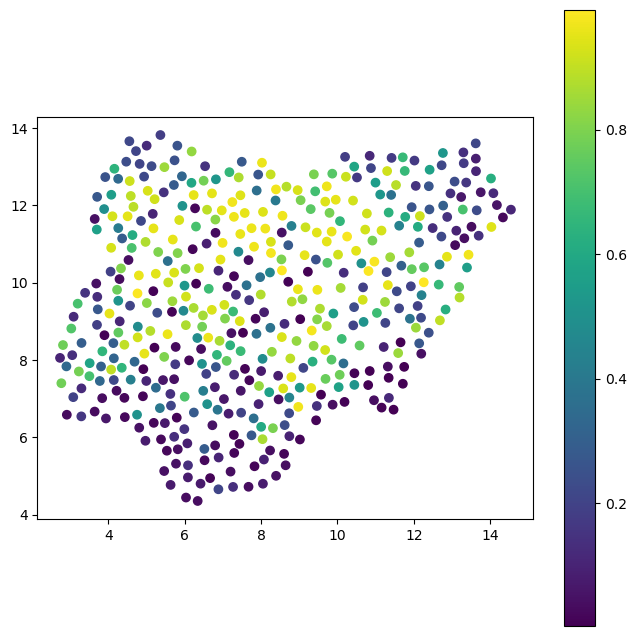

In [110]:
gdf.plot(column='preds', legend=True, figsize=(8, 8))

<AxesSubplot:>

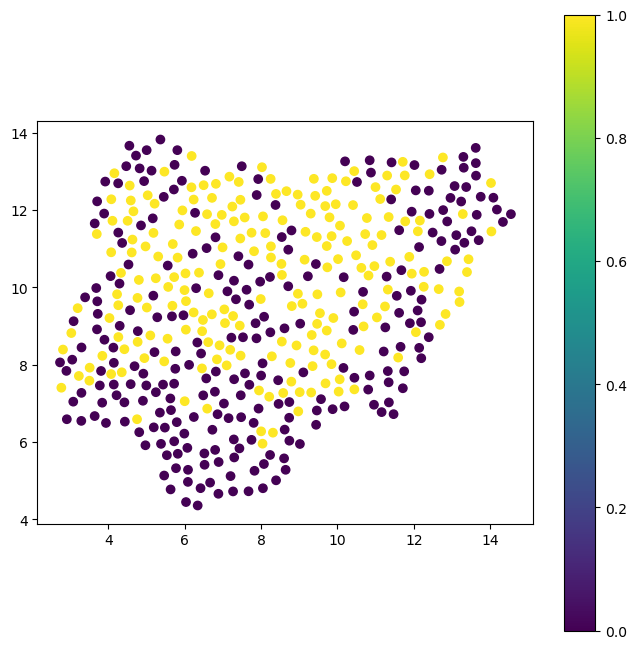

In [111]:
gdf.plot(column='preds_thr0.5', legend=True, figsize=(8, 8))

<AxesSubplot:>

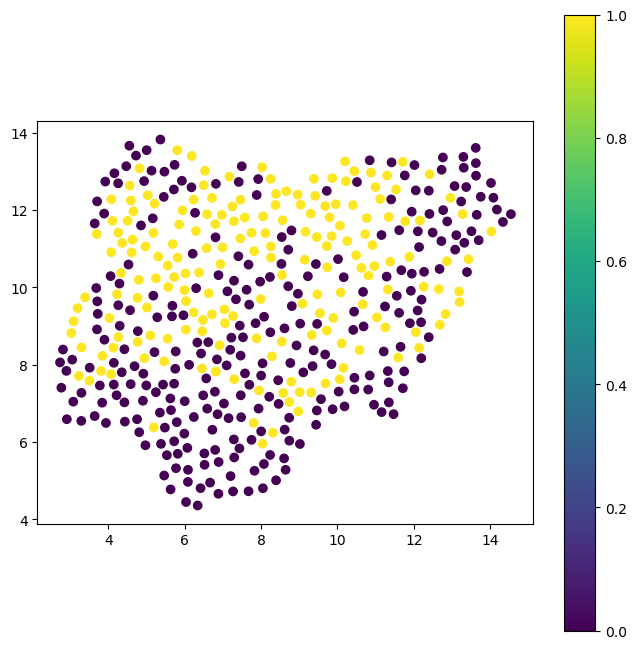

In [112]:
gdf.plot(column='is_crop', legend=True, figsize=(8, 8))

### Results on validations set

In [ ]:
results = load_and_test_model(checkpoint_path, 'validation')

Testing model ../data/lightning_logs/version_949/checkpoints/epoch=22.ckpt on validation set
Found normalizing dict geowiki_normalizing_dict_Nigeria.h5
Loading normalizing dict geowiki_normalizing_dict_Nigeria.h5
Creating Geowiki train split
Creating Geowiki val split
Number of instances in Geowiki training set: 361
Number of instances in Nigeria training set: 913
Total number of files used for training: 1274
Number of instances in Geowiki validation set: 91
Number of instances in Nigeria validation set: 454
Total number of files used for validation: 545


GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of global labels: 1819
Number of local labels: 0
Global class weights: tensor([1.9249, 2.0812])
Local class weights: None
Number of model parameters: 25473
Number of instances in Nigeria validation set: 454


Testing: 0it [00:00, ?it/s]

confusion matrix: [[224, 49], [37, 144]]
Saving test results at /mnt/Data/jgajardo/code/togo-crop-mask/results/dry_runs/lstm/20231116_120854.json
Number of instances in Nigeria validation set: 454
--------------------------------------------------------------------------------
TEST RESULTS
{'add_geowiki': True,
 'add_nigeria': True,
 'final_epoch': 1,
 'geowiki_subset': 'nigeria',
 'hidden_vector_size': 64,
 'log_dir': '/mnt/Data/jgajardo/code/togo-crop-mask/notebooks/lightning_logs/version_6',
 'multi_headed': False,
 'num_rnn_layers': 1,
 'test_FN': 37,
 'test_FP': 49,
 'test_TN': 224,
 'test_TP': 144,
 'test_accuracy': 0.8105726872246696,
 'test_f1_score': 0.7700534759358288,
 'test_loss': 0.7738813161849976,
 'test_on': 'validation',
 'test_precision_score': 0.7461139896373057,
 'test_recall_score': 0.7955801104972375,
 'test_roc_auc_score': 0.896241879667294,
 'weighted_loss_fn': True}
--------------------------------------------------------------------------------
